In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt
from monty.serialization import loadfn

ct = True

In [2]:
old_ct = pd.read_csv("OldData/OldDataFullCT.csv")
new_ct = pd.read_csv("NewData/charge_throughputs_BA.csv")

In [3]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [4]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5',
                       'X.integrated_time_temperature_cycles_1:100']
#                        'X.min_internal_resistance_cycles_2:100',
#                        'X.internal_resistance_difference_cycles_2:100']

internal_resistance = ['X.min_internal_resistance_cycles_2:100', 
                       'X.internal_resistance_difference_cycles_2:100']

if ct:
    y = 'charge_throughput'
else:
    y = 'X.capacity_0.8'

In [5]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [6]:
rmses = []

## Old Data

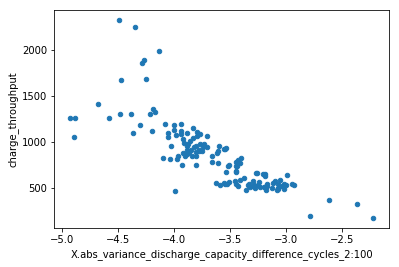

In [7]:
old_ct.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = y)

In [8]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

### Variance Model

In [9]:
# Variance model
X_train_var = old_ct.iloc[train_ind][[variance_model_features]]
y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][[variance_model_features]]
y_test = old_ct.iloc[test_ind][[y]]

In [10]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

rmses.append(rmse_test_var)
print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  282.92191713852736
Test RMSE:  214.3005991050382
Mean % Train Error:  0.2188573334295044
Mean % Test Error:  0.14850105828362203


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

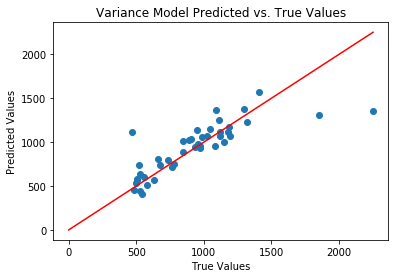

In [11]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [12]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

rmses.append(rmse_test_var_en)
print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 1.0
Test RMSE:  214.31490921731066


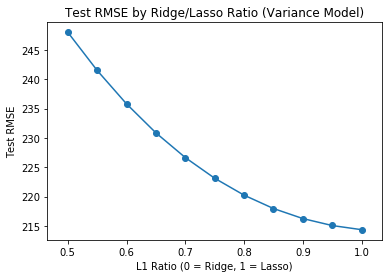

In [13]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

### Discharge Model

In [14]:
# discharge model
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

rmses.append(rmse_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))

Discharge Basic Linear Regression Model
Training RMSE:  198.98052994567502
Test RMSE:  335.350991018547


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

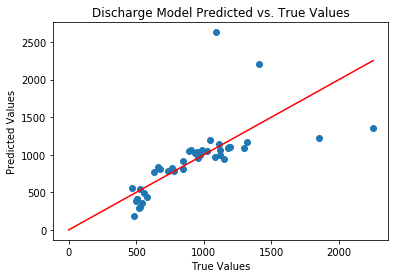

In [15]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [16]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

rmses.append(rmse_test_dis_en)

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.7
Test RMSE:  233.07893264338523


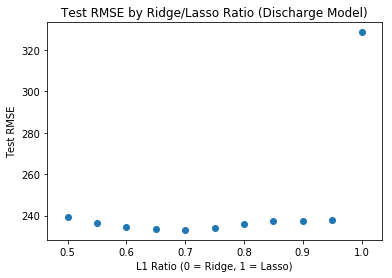

In [17]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

### Full Model

In [18]:
# full model
X_train_full = old_ct.iloc[train_ind][full_model_features + internal_resistance]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features + internal_resistance]
y_test = old_ct.iloc[test_ind][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

rmses.append(rmse_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  181.94226670313935
Test RMSE:  215.9008870735421
Mean % Train Error:  0.16966614751126105
Mean % Test Error:  0.17037614940022838


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

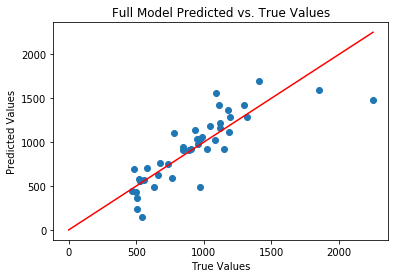

In [19]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [20]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

rmses.append(rmse_test_full_en)

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 0.05
Test RMSE:  365.10817653790923


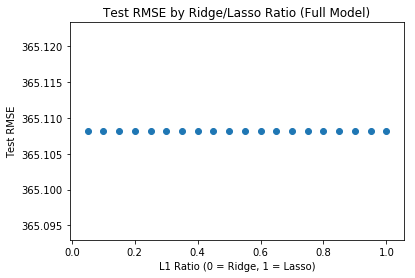

In [21]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

## New Data

In [22]:
new_df = pd.read_csv("NewData/LFPBatteries.csv")

In [23]:
new_ct["battery_index"] = new_ct["battery"].str[-2:].astype('int')

In [24]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)

In [25]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

### Variance Model

In [26]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][[variance_model_features]]
y_train = new_ct_full.iloc[train_ind][[y]]

X_test_var = new_ct_full.iloc[test_ind][[variance_model_features]]
y_test = new_ct_full.iloc[test_ind][[y]]

In [27]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)


rmses.append(rmse_test_var)
print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  497.39122141962434
Test RMSE:  626.8553139149482
Mean % Train Error:  0.13972198795934596
Mean % Test Error:  0.15944604392611542


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

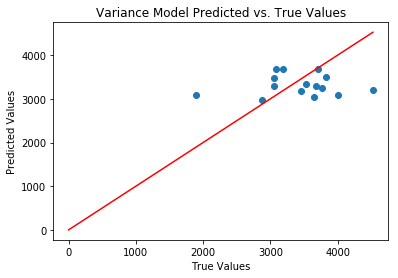

In [28]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [29]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

rmses.append(rmse_test_var_en)

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 0.95
Test RMSE:  610.0412341611211


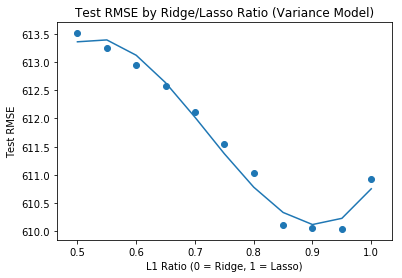

In [30]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

### Discharge Model

In [31]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

rmses.append(rmse_test_dis)
print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
# print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  332.6158412163993
Test RMSE:  543.4380606624114


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

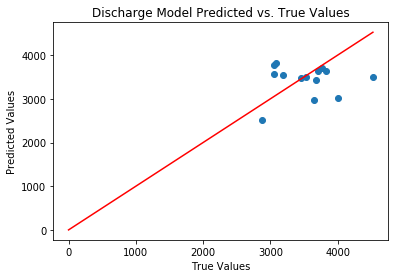

In [32]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [33]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

rmses.append(rmse_test_dis_en)
print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.5
Test RMSE:  474.2329179322816


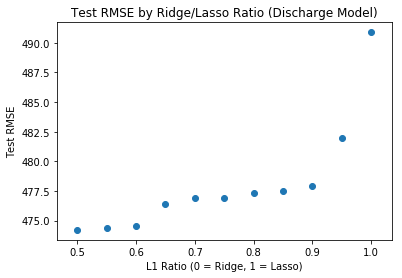

In [34]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

### Full Model

In [35]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_test = new_ct_full.iloc[X_test_full.index][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

rmses.append(rmse_test_full)
print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  235.70674037531566
Test RMSE:  390.88938326953104
Mean % Train Error:  0.048179538730917605
Mean % Test Error:  0.08009727377168961


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

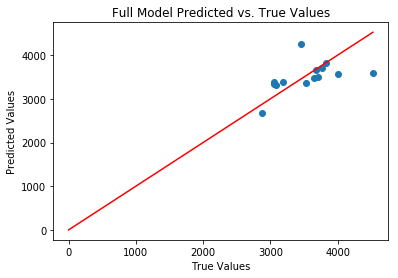

In [36]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [37]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

rmses.append(rmse_test_full_en)
print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 0.1
Test RMSE:  487.3086357939832


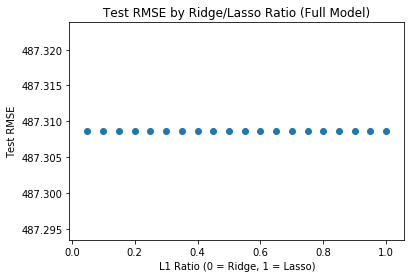

In [38]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

## New + Old Data

In [39]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [40]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

train_ind = train_ind + list(range(old_ct.shape[0],old_ct.shape[0] + new_ct.shape[0], 2))
test_ind = test_ind + list(range(old_ct.shape[0] + 1,old_ct.shape[0] + new_ct.shape[0], 2))

### Variance Model

In [41]:
# Variance model
X_train_var = full_data.iloc[train_ind][[variance_model_features]]
y_train = full_data.iloc[train_ind][[y]]

X_test_var = full_data.iloc[test_ind][[variance_model_features]]
y_test = full_data.iloc[test_ind][[y]]

In [42]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

rmses.append(rmse_test_var)
print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  1090.7564316355467
Test RMSE:  1038.1997802132096
Mean % Train Error:  0.9623943118060654
Mean % Test Error:  0.7956635913505595


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

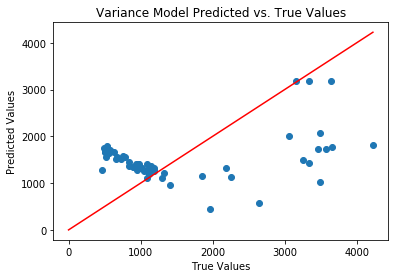

In [43]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [44]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

rmses.append(rmse_test_var_en)

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 0.6
Test RMSE:  1032.0534867309402


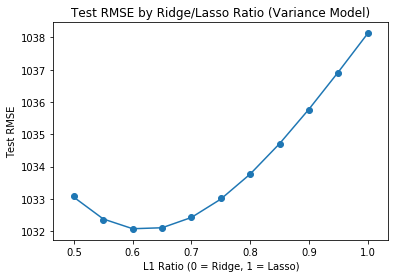

In [45]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

### Discharge Model

In [46]:
# discharge model
X_train_dis = full_data.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
y_train = full_data.iloc[X_train_dis.index][[y]]

X_test_dis = full_data.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
y_test = full_data.iloc[X_test_dis.index][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

rmses.append(rmse_test_dis)


print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
# print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  526.386114347237
Test RMSE:  613.3301990818047


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

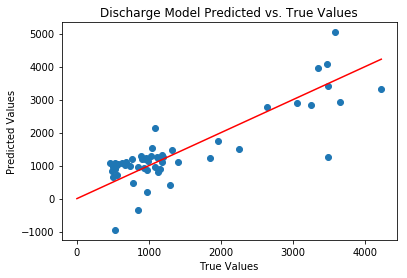

In [47]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [48]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

rmses.append(rmse_test_dis_en)

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.8
Test RMSE:  611.463451222934


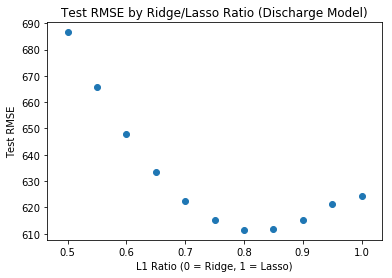

In [49]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

### Full Model

In [50]:
# full model
X_train_full = full_data.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
y_train = full_data.loc[X_train_full.index][[y]]

X_test_full = full_data.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
y_test = full_data.loc[X_test_full.index][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

rmses.append(rmse_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  263.09967590127343
Test RMSE:  540.5703754215822
Mean % Train Error:  0.15317230113443953
Mean % Test Error:  0.20194318176256468


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

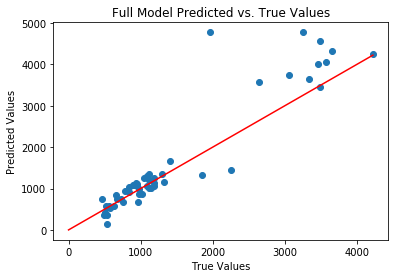

In [51]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [52]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

rmses.append(rmse_test_full_en)

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 1.0
Test RMSE:  757.4743207373535


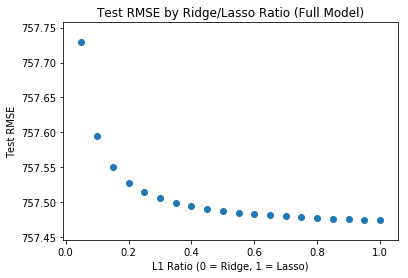

In [53]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

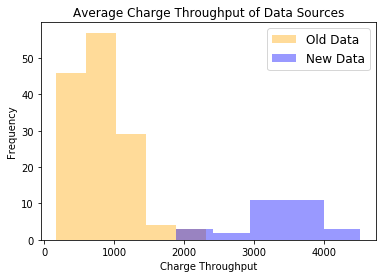

In [54]:
sns.distplot(old_ct[y], kde=False, color="orange", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="blue", label='New Data', bins=5)

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

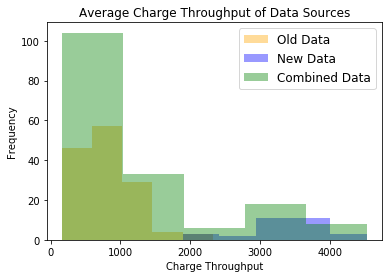

In [55]:
sns.distplot(old_ct[y], kde=False, color="orange", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="blue", label='New Data', bins=5)
sns.distplot(full_data[y], kde = False, color = "green", label = 'Combined Data', bins = 5)
# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

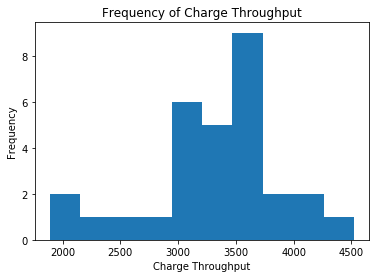

In [56]:
plt.hist(new_ct_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life (New Data)')

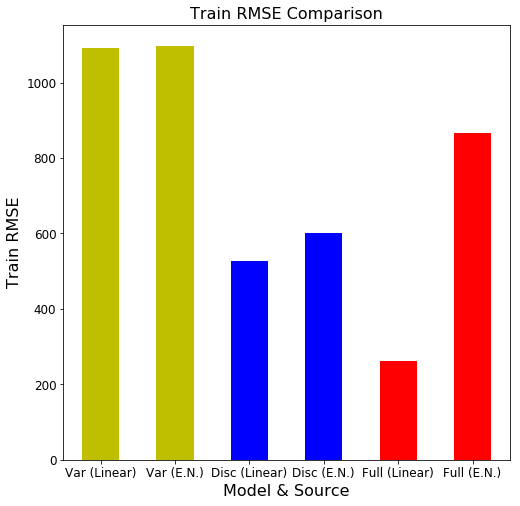

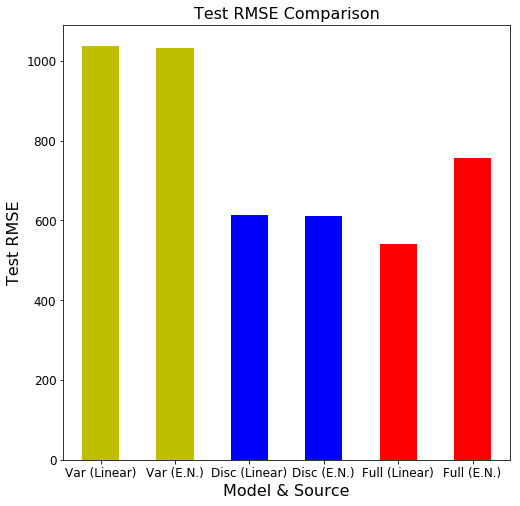

In [57]:
new_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                           "Disc (Linear)", "Disc (E.N.)",
                                                           "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en,]})#,


for column in new_data_metrics.columns[3:]:
    ax = new_data_metrics.plot.bar(x='Model & Source', y=column, rot=0,
                         fontsize = 12, legend=False, figsize = (8,8),
                         color = ["y","y","b","b","r","r"])

    ax.set_xlabel("Model & Source", fontsize = 16)
    ax.set_ylabel(column, fontsize=16)
    ax.set_title(column + " Comparison", fontsize=16)
    plt.show()

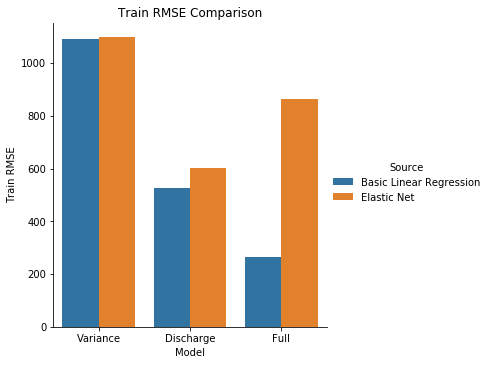

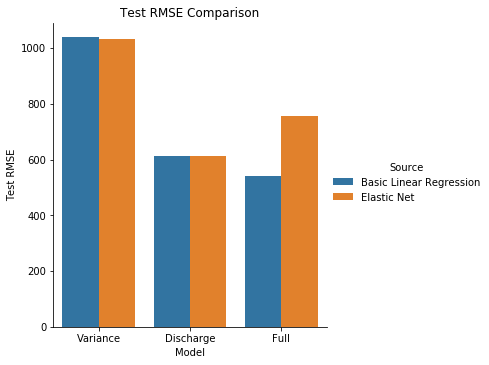

In [58]:
for column in new_data_metrics.columns[3:5]:
    sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")

In [59]:
pd.DataFrame([[round(rmse_test_var), round(rmse_test_var_en), "Variance"], 
              [round(rmse_test_dis), round(rmse_test_dis_en), "Discharge"], 
              [round(rmse_test_full), round(rmse_test_full_en), "Full"]], 
              columns = ["Basic Linear Regression RMSE", "Elastic Net RMSE", "Model"]
            ).set_index("Model")

,Basic Linear Regression RMSE,Elastic Net RMSE
Model,,
Variance,1038.0,1032.0
Discharge,613.0,611.0
Full,541.0,757.0


In [ ]:
new_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                           "Disc (Linear)", "Disc (E.N.)",
                                                           "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                               "Data": 
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
#                                "Train RMSE": [rmses[0], rmse_train_var_en,
#                                               rmse_train_dis, rmse_train_dis_en,
#                                               rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmses[0], rmses[1],
                                             rmses, rmses,
                                             rmses, rmses]})#,


for column in new_data_metrics.columns[3:]:
    ax = new_data_metrics.plot.bar(x='Model & Source', y=column, rot=0,
                         fontsize = 12, legend=False, figsize = (8,8),
                         color = ["y","y","b","b","r","r"])

    ax.set_xlabel("Model & Source", fontsize = 16)
    ax.set_ylabel(column, fontsize=16)
    ax.set_title(column + " Comparison", fontsize=16)
    plt.show()

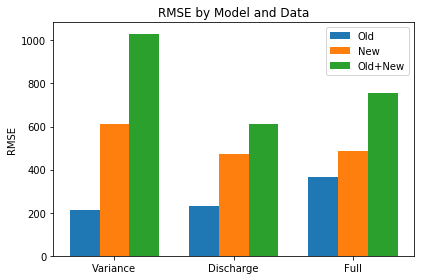

In [73]:
kind = ["Variance", "Discharge", "Full"]
data = ["Old", "New", "Old+New"]
# rme_var = [rmses[1], rmses[7], rmses[13]]
# rme_dis = [rmses[3], rmses[9], rmses[15]]
# rme_full = [rmses[5], rmses[11], rmses[17]]
rme_var = [rmses[1], rmses[3], rmses[5]]
rme_dis = [rmses[7], rmses[9], rmses[11]]
rme_full = [rmses[13], rmses[15], rmses[17]]

x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, rme_var, width, label=data[0])
rects2 = ax.bar(x, rme_dis, width, label=data[1])
rects3 = ax.bar(x + width, rme_full, width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

In [72]:
rmses

[214.3005991050382,
 214.31490921731066,
 335.350991018547,
 233.07893264338523,
 215.9008870735421,
 365.10817653790923,
 626.8553139149482,
 610.0412341611211,
 543.4380606624114,
 474.2329179322816,
 390.88938326953104,
 487.3086357939832,
 1038.1997802132096,
 1032.0534867309402,
 613.3301990818047,
 611.463451222934,
 540.5703754215822,
 757.4743207373535]

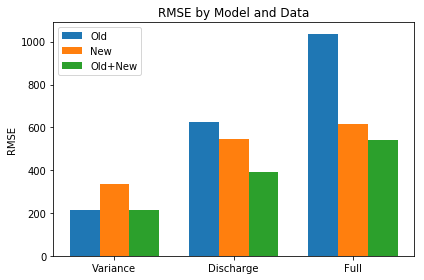

In [70]:
kind = ["Variance", "Discharge", "Full"]
data = ["Old", "New", "Old+New"]
rme_var = [rmses[0], rmses[6], rmses[12]]
rme_dis = [rmses[2], rmses[8], rmses[14]]
rme_full = [rmses[4], rmses[10], rmses[16]]


x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, rme_var, width, label=data[0])
rects2 = ax.bar(x, rme_dis, width, label=data[1])
rects3 = ax.bar(x + width, rme_full, width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

In [71]:
rmses

[214.3005991050382,
 214.31490921731066,
 335.350991018547,
 233.07893264338523,
 215.9008870735421,
 365.10817653790923,
 626.8553139149482,
 610.0412341611211,
 543.4380606624114,
 474.2329179322816,
 390.88938326953104,
 487.3086357939832,
 1038.1997802132096,
 1032.0534867309402,
 613.3301990818047,
 611.463451222934,
 540.5703754215822,
 757.4743207373535]